## Part 1 – image_load(path, channel)


In [1]:
import cv2
import numpy as np

def image_load(path, channel=None):
    """
    Load an image in gray (channel=1) or RGB (channel=3).
    If channel=None, detect automatically from the file.
    """
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    assert img is not None, f"Cannot load image at {path}"
    # auto‐detect
    if channel is None:
        channel = 1 if img.ndim == 2 else 3
    # force gray
    if channel == 1:
        if img.ndim == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # force RGB
    else:
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


## Part 2 – convolve_channel() + apply_convolution() with output‐shape assertions


In [2]:
import numpy as np

def convolve_channel(image, kernel):
    h, w = image.shape
    kh, kw = kernel.shape
    assert h >= kh and w >= kw, "Image too small for this kernel"
    pad_h, pad_w = kh//2, kw//2
    padded = np.pad(image, ((pad_h,pad_h),(pad_w,pad_w)), mode='constant')
    out = np.zeros_like(image, dtype=np.float32)
    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            out[i,j] = np.sum(region * kernel)
    assert out.shape == image.shape, f"Output shape {out.shape} ≠ input {image.shape}"
    return out

def apply_convolution(image, kernel):
    """
    Handles grayscale (2D) or RGB (3D) input, applies kernel on each channel,
    clips to [0,255], asserts output shape = input shape.
    """
    assert isinstance(image, np.ndarray) and isinstance(kernel, np.ndarray)
    assert kernel.ndim == 2 and kernel.shape[0] == kernel.shape[1] and kernel.shape[0] % 2 == 1
    assert image.ndim in (2,3)
    if image.ndim == 3:
        assert image.shape[2] == 3, "RGB image must have 3 channels"
        out = np.zeros_like(image, dtype=np.float32)
        for c in range(3):
            out[:,:,c] = convolve_channel(image[:,:,c], kernel)
    else:
        out = convolve_channel(image, kernel)
    out = np.clip(out, 0, 255).astype(np.uint8)
    assert out.shape == image.shape, f"Output shape {out.shape} ≠ input {image.shape}"
    return out


## Part 3 – simple display_images() → later you’ll expand to show multiple filters



In [3]:
import matplotlib.pyplot as plt

def display_images(original, filtered, title):
    """
    Show original and one filtered image side by side.
    filtered can be 2D or 3D.
    """
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(original, cmap='gray' if original.ndim==2 else None)
    plt.subplot(1,2,2)
    plt.title(title)
    plt.axis('off')
    plt.imshow(filtered, cmap='gray' if filtered.ndim==2 else None)
    plt.show()


## Part 4 – define all requested kernels




In [4]:
import numpy as np

kernels = {
    "Blur 3×3": np.ones((3,3))/9,
    "Sobel H":  np.array([[-1,0,1],[-2,0,2],[-1,0,1]]),
    "Sobel V":  np.array([[-1,-2,-1],[0,0,0],[1,2,1]]),
    "Sharpen":  np.array([[0,-1,0],[-1,5,-1],[0,-1,0]]),
    "Emboss":   np.array([[-2,-1,0],[-1,1,1],[0,1,2]]),
    "Prewitt H": np.array([[-1,0,1],[-1,0,1],[-1,0,1]]),
    "Prewitt V": np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
}

# random filters
for size in (3,5,7):
    np.random.seed(42 + size)
    R = np.random.randn(size,size)
    kernels[f"Random {size}×{size}"] = R / np.sum(np.abs(R))


## Part 5 – loading one image, applying every kernel, showing results


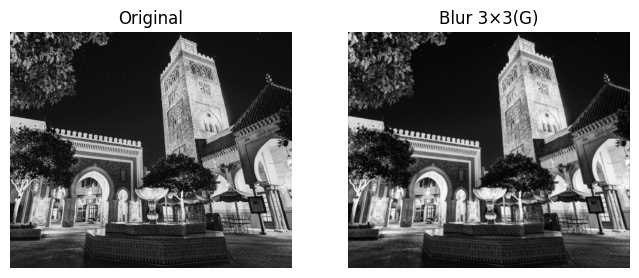

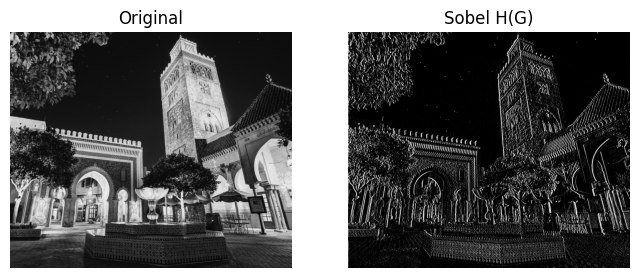

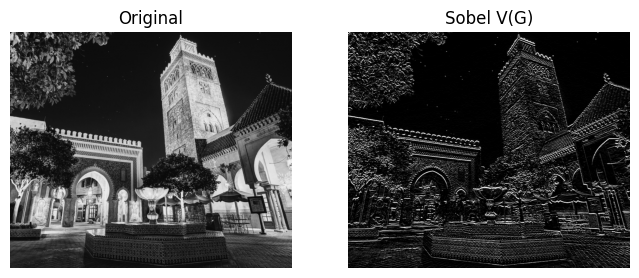

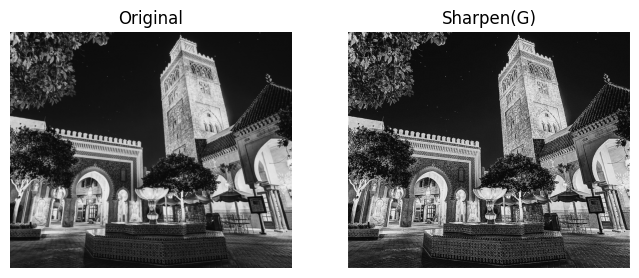

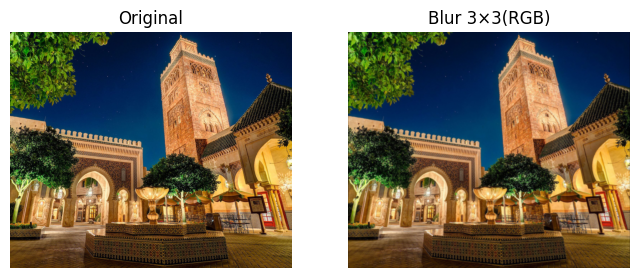

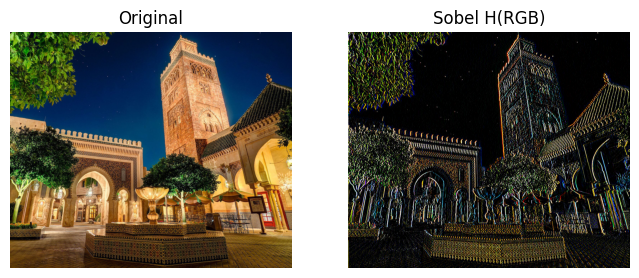

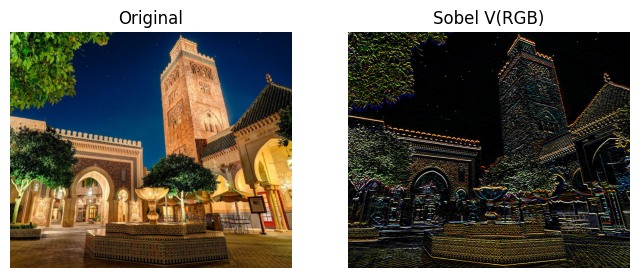

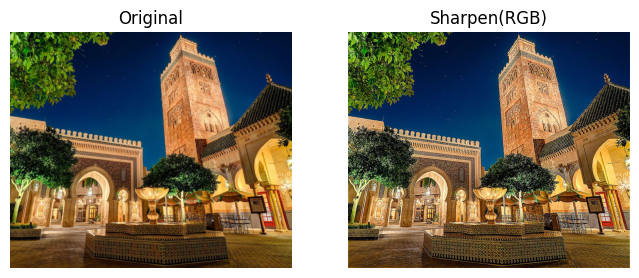

In [5]:
# load a test image (replace with your filename)
img_gray = image_load("img2.png", channel=1)
img_rgb  = image_load("img1.png", channel=3)

# apply each filter on gray and RGB
results_gray = {name: apply_convolution(img_gray, K) for name,K in kernels.items()}
results_rgb  = {name: apply_convolution(img_rgb,  K) for name,K in kernels.items()}

# display first few results in loop
for name, out in list(results_gray.items())[:4]:
    display_images(img_gray, out, f"{name}(G)")
for name, out in list(results_rgb.items())[:4]:
    display_images(img_rgb, out, f"{name}(RGB)")
